In [ ]:
import scipy.io
from scipy.optimize import linprog
import math
import numpy as np
from numpy import *
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.patches import ConnectionPatch


In [ ]:
points = scipy.io.loadmat('ListInputPoints.mat')['ListInputPoints']

Reformulation


**Original consensus set maximization problem.**
$${\max\limits_{\Theta,S_I}\quad{card(S_I)}}$$
$$s.t.\quad |x_i+T_x-x_i'|\le δ, \quad \forall i \in S_I ⊆ S
\\\qquad |y_i+T_y-y_i'|\le δ,  \quad \forall i\in S_I ⊆ S
$$

**Introduce binary variables $z_i$ and relax $z_i$.**
$${\max\limits_{z_i, \Theta}\quad{\sum_{i=1}^{N} z_i}}$$
$$s.t.\quad z_i|x_i+T_x-x_i'|\le z_iδ, \quad \forall i = 1...N
\\\qquad z_i|y_i+T_y-y_i'|\le z_i δ,  \quad \forall i=1...N
\\\qquad 0\le z_i \le 1, \quad \forall i = 1...N
$$

**indtroduce auxiliary variables $w_{ix} = z_iT_x$ and $w_{iy}=z_iT_y$, Replace bilinear terms using concave and convex envelopes.**
$${\min\limits_{z_i, T_x, T_y, w_{ix}, w_{iy}}{\sum_{i=1}^{N} -z_i}}$$
$$s.t.\quad z_i|x_i+T_x-x_i'|\le z_iδ, \quad \forall i=1...N
\\\qquad z_i|y_i+T_y-y_i'|\le z_iδ,  \quad \forall i=1...N
\\\qquad conv(z_iT_x)≤w_{ix}≤conc(z_iT_x), \quad  i = 1...N
\\\qquad conv(z_iT_y)≤w_{iy}≤conc(z_iT_y),  \quad  i = 1...N
\\\qquad \underline{T_x} \le T_x \le \overline{T_x}, \ \underline{T_y} \le T_y \le \overline{T_y}  
\\\qquad 0\le z_i \le 1, \quad \forall i=1...N
$$

**Reformulate the constraints in canonical form.**
$${\min\limits_{z_i, T_x, T_y, w_{ix}, w_{iy}}{\sum_{i=1}^{N} -z_i}}$$
\begin{align}
s.t.\qquad z_i(x_i-x_i'+δ)+w_{ix}\le 0, \quad \forall i=1...N \\
z_i(-x_i+x_i'-δ)-w_{ix}\le 0,  \quad \forall i=1...N \\
z_i(y_i-y_i'+δ)+w_{iy}\le 0, \quad \forall i=1...N
\\ z_i(-y_i+y_i'-δ)-w_{iy}\le 0,  \quad \forall i=1...N
\\ \underline{T_x}z_i-w_{ix}\le 0, \quad \forall i=1...N
\\ -\overline{T_x}z_i+w_{ix}\le 0, \quad \forall i=1...N
\\ T_x+\overline{T_x}z_i-w_{ix}\le \overline{T_x}, \quad \forall i=1...N
\\ -T_x-\underline{T_x}z_i+w_{ix}\le -\underline{T_x}, \quad \forall i=1...N
\\\underline{T_y}z_i-w_{iy}\le 0, \quad \forall i=1...N
\\ -\overline{T_y}z_i+w_{iy}\le 0, \quad \forall i=1...N
\\ T_y+\overline{T_y}z_i-w_{iy}\le \overline{T_y}, \quad \forall i=1...N
\\-T_y-\underline{T_y}z_i+w_{iy}\le -\underline{T_y}, \quad \forall i=1...N
\\0\le z_i \le 1, \quad \forall i=1...N
\end{align}
$$\qquad\qquad\quad \underline{T_x} \le T_x \le \overline{T_x} ,\quad \underline{T_y} \le T_y \le \overline{T_y}$$

**Consider Algebraic representation**
$${\min\limits_{x}{c^Tx}}$$
$$s.t.\  Ax\le b \\
l\le x \le u$$
where $$x = [T_x,T_y,z_1,..,z_n,w_{1x},..,w_{nx},w_{1y},..,w_{ny}], \\
c = [0,0,-1,..,-1,0,..,0,0,..,0]\\
l = [\underline{T_x},\underline{T_y},0,..,0,-inf,..,-inf,-inf,..,-inf]\\
u = [\overline{T_x},\overline{T_y},1,..,1,inf,..,inf,inf,..,inf]\\\\
dimension(A) = (12N,3N+2)$$

In [ ]:
def compute_lower_bound(optimizer, points, inlier_threshold):
  is_inlier = np.logical_and((abs(points[:,0]-points[:,2]+optimizer[0]) <= inlier_threshold),(abs(points[:,1]-points[:,3]+optimizer[1]) <= inlier_threshold))
  inlier_lb = np.sum(is_inlier)
  
  return inlier_lb

In [ ]:
def LP_compute_upper_bound(points,A,b,bound_box): 

  lb_x = np.zeros(3*N+2)
  ub_x = np.zeros(3*N+2)

  Tx_lb = bound_box[0][0]
  Ty_lb = bound_box[1][0]
  Tx_ub = bound_box[0][1]
  Ty_ub = bound_box[1][1]
  

  lb_x[0:2] = [Tx_lb,Ty_lb]
  ub_x[0:2] = [Tx_ub,Ty_ub]

  lb_x[2:N+2] = 0
  ub_x[2:N+2] = 1

  lb_x[N+2:] = None
  ub_x[N+2:] = None

  bound = []
  for i in range(len(lb_x)):
    bound.append((lb_x[i],ub_x[i]))


  A[4*N:5*N,2:N+2] = Tx_lb * np.identity(N)
  A[4*N:5*N,N+2:2*N+2] = -np.identity(N)

  A[5*N:6*N,0] = 1
  A[5*N:6*N,2:N+2] = Tx_ub * np.identity(N)
  A[5*N:6*N,N+2:2*N+2] = -np.identity(N)
  b[5*N:6*N] = Tx_ub 

  A[6*N:7*N,0] = -1
  A[6*N:7*N,2:N+2] = -Tx_lb * np.identity(N)
  A[6*N:7*N,N+2:2*N+2] = np.identity(N)
  b[6*N:7*N] = -Tx_lb 

  A[7*N:8*N,2:N+2] = -Tx_ub * np.identity(N)
  A[7*N:8*N,N+2:2*N+2] = np.identity(N)  

  A[8*N:9*N,2:N+2] = Ty_lb * np.identity(N)
  A[8*N:9*N,2*N+2:] = -np.identity(N)

  A[9*N:10*N,1] = 1
  A[9*N:10*N,2:N+2] = Ty_ub * np.identity(N)
  A[9*N:10*N,2*N+2:] = -np.identity(N)
  b[9*N:10*N] = Ty_ub 

  A[10*N:11*N,1] = -1
  A[10*N:11*N,2:N+2] = -Ty_lb * np.identity(N)
  A[10*N:11*N,2*N+2:] = np.identity(N)
  b[10*N:11*N] = -Ty_lb 

  A[11*N:12*N,2:N+2] = -Ty_ub * np.identity(N)
  A[11*N:12*N,2*N+2:] = np.identity(N)  

  x = scipy.optimize.linprog(c ,A_ub = A, b_ub = b, bounds = bound,options={'sym_pos':False,'lstsq':True})
  np.set_printoptions(threshold=np.inf)
  res = x.x
  nb = np.sum(res[2:N+2])
  
  
  return nb,res[0:2]

In [ ]:
#initialization
N = points.shape[0]
inlier_threshold = 3
accuracy = 1

#initial box bound
Tx_ub = np.amax(points[:,0]-points[:,2])
Tx_lb = np.amin(points[:,0]-points[:,2])
Ty_ub = np.amax(points[:,1]-points[:,3])
Ty_lb = np.amin(points[:,1]-points[:,3])

#inlier bound
ObjLB = 0
ObjUB = 0

#initialize LP matrix
A = np.zeros((12*N,3*N+2))

A[:N,2:N+2] = np.diag(points[:,0]-points[:,2] - inlier_threshold)
A[:N,N+2:2*N+2] = np.identity(N)

A[N:2*N,2:N+2] = np.diag(-points[:,0] + points[:,2] - inlier_threshold)
A[N:2*N,N+2:2*N+2] = -np.identity(N)

A[2*N:3*N,2:N+2] = np.diag(points[:,1]-points[:,3] - inlier_threshold)
A[2*N:3*N,2*N+2:] = np.identity(N)

A[3*N:4*N,2:N+2] = np.diag(-points[:,1] + points[:,3] - inlier_threshold)
A[3*N:4*N,2*N+2:] = -np.identity(N)

b = np.zeros(12*N)
c = np.zeros(3*N+2)
c[2:N+2] = -1


In [ ]:
#innitialize Objub,Objlb
Objub, optimizer = LP_compute_upper_bound(points,A,b,([Tx_lb,Tx_ub],[Ty_lb,Ty_ub]))
Objlb = compute_lower_bound(optimizer, points, inlier_threshold)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [ ]:
#interation
List_bound =[[([Tx_lb,Tx_ub],[Ty_lb,Ty_ub]),Objlb,Objub,optimizer]]

Objub_list = [Objub]
Objlb_list = [Objlb]
k = 0 

while Objub_list[k] - Objlb_list[k] >= accuracy:

  for i in range(len(List_bound)):

    if List_bound[i][2] ==  Objub_list[k]:
      bound_tem = List_bound[i][0]

      if bound_tem[0][1] - bound_tem[0][0] >= bound_tem[1][1] - bound_tem[1][0]:
        child1 = ([bound_tem[0][0],mean(bound_tem[0])],bound_tem[1]) 
        child2 = ([mean(bound_tem[0]),bound_tem[0][1]],bound_tem[1]) 
      else :
        child1 = (bound_tem[0],[bound_tem[1][0],mean(bound_tem[1])])
        child2 = (bound_tem[0],[mean(bound_tem[1]),bound_tem[1][1]])
      break
  
  del List_bound[i]

  Objub_c1, optimizer_c1 = LP_compute_upper_bound(points,A,b,child1)
  Objlb_c1 = compute_lower_bound(optimizer_c1, points, inlier_threshold)

  Objub_c2, optimizer_c2 = LP_compute_upper_bound(points,A,b,child2)
  Objlb_c2 = compute_lower_bound(optimizer_c2, points, inlier_threshold) 

  List_bound.append([child1,Objlb_c1,Objub_c1,optimizer_c1])
  List_bound.append([child2,Objlb_c2,Objub_c2,optimizer_c2])

  max = 0
  min = 0

  for i in range(len(List_bound)):
    if max < List_bound[i][2]:
      max = List_bound[i][2]
    if min < List_bound[i][1]:
      min = List_bound[i][1]

  Objub_list.append(max)
  Objlb_list.append(min)

  List_bound_tem = List_bound.copy()
  
  for i in range(len(List_bound)):
    if math.ceil(List_bound[i][2]) < min:  
      List_bound_tem.remove(List_bound[i])

  List_bound = List_bound_tem

  k += 1

print('the inlier number = ',Objub_list[k])

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


the inlier number =  14.999997288989693


In [ ]:
## the indices of inliers and outliers
optimizer_final = List_bound[0][3]

is_inlier = np.logical_and((abs(points[:,0]-points[:,2]+optimizer_final[0]) <= inlier_threshold),(abs(points[:,1]-points[:,3]+optimizer_final[1]) <= inlier_threshold))
indices_in = points[is_inlier]
indices_out = points[is_inlier == False]
print('inliers indices are:\n',indices_in,'\noutliers indices are:\n',indices_out)

inliers indices are:
 [[ 816.75  493.25  581.75  336.25]
 [ 984.75  302.75  749.75  145.75]
 [ 344.25  256.25  109.25   99.25]
 [ 666.75  187.25  431.75   30.25]
 [ 509.25  470.75  274.25  313.75]
 [1085.25  491.75  850.25  334.75]
 [ 884.25  509.75  649.25  352.75]
 [ 891.75  280.25  656.75  123.25]
 [ 689.25  415.25  454.25  258.25]
 [1055.25  337.25  820.25  180.25]
 [ 897.75  247.25  662.75   90.25]
 [ 393.75  373.25  158.75  216.25]
 [ 851.25  467.75  616.25  310.75]
 [ 998.25  418.25  763.25  261.25]
 [ 728.25  253.25  493.25   96.25]] 
outliers indices are:
 [[1098.  470. 1063.  373.]
 [ 653.  500.  214.  238.]
 [ 446.  514.  530.  128.]
 [ 457.  170.  292.  417.]
 [1096.  441.  469.  401.]
 [ 128.   29.  337.  319.]
 [ 548.  353.  245.  460.]
 [1099.  103.  863.  108.]
 [ 206.  106.  378.  513.]
 [1082.  157.  657.  529.]
 [ 438.  388.  617.  416.]
 [ 718.  536.   84.  323.]
 [ 432.  150.  168.  219.]
 [ 706.  141.   98.  461.]
 [ 254.  317.  895.  222.]
 [ 352.   74.  742.  31

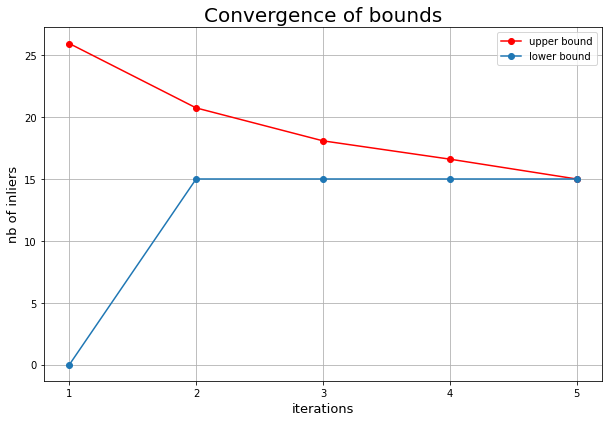

In [ ]:
##figure of the convergence of the cardinatlity bounds
for i in range(1,len(Objlb_list)):
  if Objlb_list[i] < Objlb_list[i-1]:
    Objlb_list[i] = Objlb_list[i-1]

plt.figure(figsize=(10, 6.5))
plt.plot(range(1,k+1), Objub_list[1:],'ro-',label = 'upper bound')
plt.plot(range(1,k+1), Objlb_list[1:],'o-',label = 'lower bound')

plt.grid(b=None, which='major', axis='both')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.title('Convergence of bounds', fontdict={'fontsize':20})
plt.xlabel("iterations",fontsize=13)
plt.ylabel("nb of inliers",fontsize=13) 

plt.legend()
plt.show()

In [ ]:
def draw_lines(points, axs, con_color = 'blue', point_color = 'bo'):

  for i in range(points.shape[0]):

    x = points[i,:2]
    y = points[i,2:]

    con = ConnectionPatch(xyA=x, xyB=y, coordsA="data", coordsB="data",
                      axesA=axs[0], axesB=axs[1], color = con_color)
    axs[1].add_artist(con)

    axs[0].plot(x[0],x[1],point_color,markersize=4)
    axs[1].plot(y[0],y[1],point_color,markersize=4)

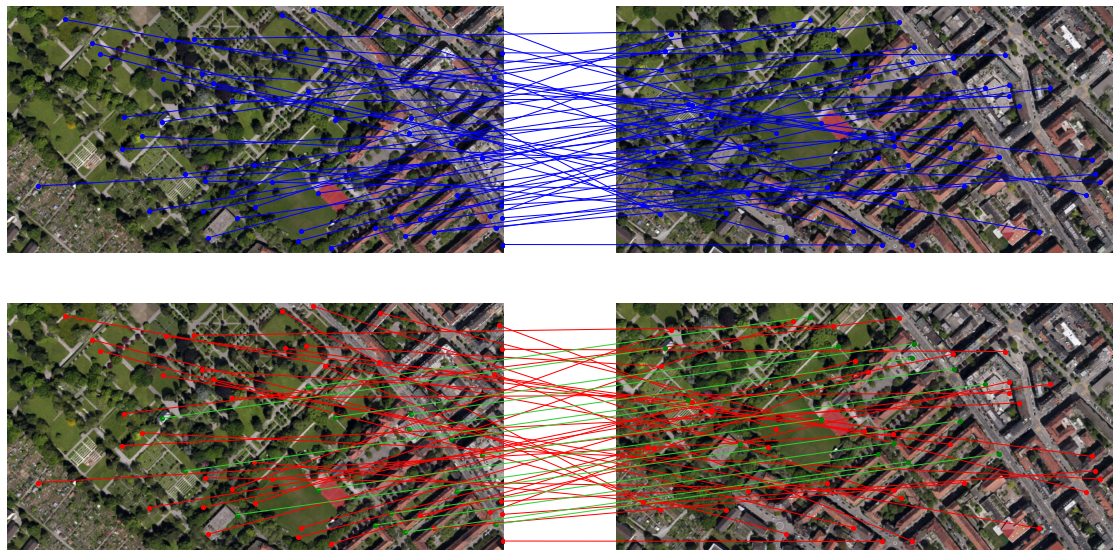

In [ ]:
##identified inlier and outlier correspondences
img1 = plt.imread('InputLeftImage.png')
img2 = plt.imread('InputRightImage.png')
imgs=[img1,img2,img1,img2]

_, axs = plt.subplots(2, 2, figsize=(20, 10))

axs = axs.flatten()

for img, ax in zip(imgs, axs):
  ax.imshow(img)
  ax.axis('off')

draw_lines(points, axs = axs[:2])
draw_lines(indices_out, axs = axs[2:], con_color = 'red', point_color = 'ro')
draw_lines(indices_in, axs = axs[2:], con_color = 'limegreen', point_color = 'go')

plt.show()